# Flow Analysis

In this notebook I want to create something that will read all of the files that we have created and make a dataframe that makes flow analysis simple.

### Folder  Structure

All data needs to be in the data folder

* Bipartite
* Monopartite
* Extinction

Also excluded bipartite as we need all nodes to have the same meaning

In [6]:
import os 
import pandas as pd

In [7]:
os.listdir('data')

['Extinction', 'Monopartite', 'Original_data', 'Bipartite']

## Fetch all network files

In [56]:
def get_all_files(path):
    files = []
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            files.append(os.path.abspath(os.path.join(dirpath, f)))
    return files

all_files = get_all_files('data') #Get all files
all_files= [f for f in all_files if f.find('Original_data')==-1] #Filter out input excel and matrix
all_files= [f for f in all_files if f.find('read')==-1] #filter readme
#all_files= [f for f in all_files if f.find('Bipartite')==-1] #filter readme

all_files

['/home/ubuntu/Information_Theory/data/Extinction/rm_plant72_num_freq_thr_0',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1083_num_freq_thr_1',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant26_freq_thr_5',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant1_freq_thr_15',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1622_freq_thr_10',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1256_num_freq_thr_0',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1671_freq_thr_15',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1679_num_freq_thr_0',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant15_freq_thr_5',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_pol1147_freq_thr_10',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant2_freq_thr_10',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant0_num_freq_thr_0',
 '/home/ubuntu/Information_Theory/data/Extinction/rm_plant3_freq_thr_15',
 '/home/ubuntu/I

## Functions to run infomap and store inputs in dataframe

In [36]:
import re 

def get_thres_f(path):
    thres_pos = path.find('freq_thr_')
    return path[thres_pos + len('freq_thr_'):]

def get_map_type(path):
    path=path.lower()
    out_type ='NA'
    map_type = ['bipartite', 'monopartite','extinction', 'genus']
    for t in map_type:
        if path.find(t)!=-1: out_type = t
    return out_type

#just fetches the next number after the search match
def get_dropped(path, drop_key='rm_plant'):
    rm_out= 'NA'
    rm = path.find(drop_key)
    if rm != -1: 
        rm_out=int(re.search(r'\d+', path[rm+len(drop_key):]).group())
    return rm_out

def run_infomap(path):
    from infomap import Infomap
    im=Infomap(silent=True)
    im.readInputData(path)
    im.run()
    
    df_ = im.get_dataframe()
    df_['thres_freq']= get_thres_f(path)
    df_['type'] = get_map_type(path)
    df_['rm_plant'] = get_dropped(path)
    df_['rm_poll'] = get_dropped(path, drop_key='rm_pol')
    
    i=0
    for cl in im.codelengths:
        if i ==0:
            df_['codelengths']=cl
        else:
            df_['codelengths_'+str(i)]
            i+=1
    df_['num_nodes'] = im.num_nodes
    df_['num_leaf_modules']=im.num_leaf_modules
    df_['max_depth']=im.max_depth
    df_['num_top_modules']=im.num_top_modules
    df_['entropy_rate'] = im.entropy_rate
    df_['relative_codelength_savings'] =im.relative_codelength_savings
     
    return df_

 ### Test on one file
 Extinction refers to mono extinction

In [37]:
run_infomap(all_files[0])

,path,flow,name,node_id,thres_freq,type,rm_plant,rm_poll,codelengths,num_nodes,num_leaf_modules,max_depth,num_top_modules,entropy_rate,relative_codelength_savings
0,"(1, 1)",0.095527,11,11,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
1,"(1, 2)",0.023411,1320,1320,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
2,"(1, 3)",0.007734,1048,1048,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
3,"(1, 4)",0.006480,1217,1217,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
4,"(1, 5)",0.005853,1412,1412,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,"(33, 3)",0.000209,28,28,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
756,"(34, 1)",0.000836,1206,1206,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
757,"(34, 2)",0.000209,48,48,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033
758,"(35, 1)",0.000418,69,69,0,extinction,72,NA,5.437905,760,36,3,35,2.993227,0.261033


## Merge all the flow data for into one dataframe

In [31]:
i=0
for f in all_files:
    if i==0:
        df=run_infomap(f)
    else:
        df=pd.concat( [df,run_infomap(f)], ignore_index=True)
    i+=1
df

,path,flow,name,node_id,thres_freq,type,rm_plant,rm_poll,entropy_rate,codelengths,num_nodes,max_depth,num_top_modules,relative_codelength_savings
0,"(1, 1)",0.095527,11,11,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
1,"(1, 2)",0.023411,1320,1320,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
2,"(1, 3)",0.007734,1048,1048,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
3,"(1, 4)",0.006480,1217,1217,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
4,"(1, 5)",0.005853,1412,1412,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,"(12, 3)",0.000000,Cerceris carinalis (Sph. : Hym. ),1159,4,bipartite,NA,NA,1.926738,2.500228,98,2,14,0.416526
12549,"(13, 1)",0.004892,rufinerve,0,4,bipartite,NA,NA,1.926738,2.500228,98,2,14,0.416526
12550,"(13, 2)",0.000000,EMPIDIDAE31 (Emp. : Dip. ),1278,4,bipartite,NA,NA,1.926738,2.500228,98,2,14,0.416526
12551,"(14, 1)",0.003914,annuus,77,4,bipartite,NA,NA,1.926738,2.500228,98,2,14,0.416526


Not sure if this makes sense does look cool though

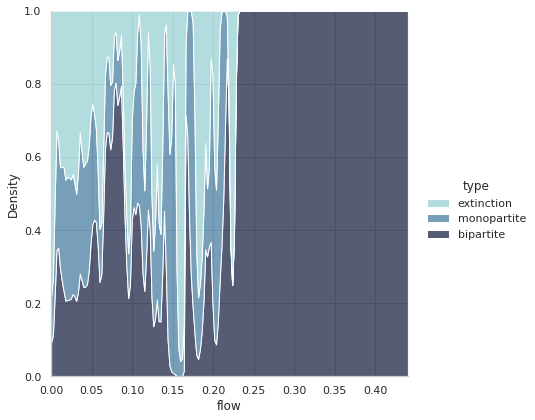

In [38]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Plot the distribution of clarity ratings, conditional on carat
sns.displot(
    data=df,
    x="flow", hue="type",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

### Identifying which models have max flow

In [39]:
df.sort_values('flow',  ascending=False)[1:10]

,path,flow,name,node_id,thres_freq,type,rm_plant,rm_poll,entropy_rate,codelengths,num_nodes,max_depth,num_top_modules,relative_codelength_savings
10468,"(1, 1)",0.427056,aemula,11,15,bipartite,NA,NA,0.778805,0.351709,18,2,6,0.859444
10437,"(1, 1)",0.389234,aemula,11,13,bipartite,NA,NA,0.948625,0.274522,31,2,11,0.909392
12320,"(1, 1)",0.385356,aemula,11,12,bipartite,NA,NA,1.060566,0.325427,34,2,11,0.895541
10399,"(1, 1)",0.362319,aemula,11,11,bipartite,NA,NA,1.100830,0.305972,38,2,12,0.905761
10131,"(1, 1)",0.349650,aemula,11,10,bipartite,NA,NA,1.127079,0.452508,39,2,11,0.863793
12408,"(1, 1)",0.302115,aemula,11,9,bipartite,NA,NA,1.265930,0.996144,47,3,11,0.723571
12354,"(1, 1)",0.300836,aemula,11,8,bipartite,NA,NA,1.439763,1.044831,54,2,12,0.714840
10628,"(1, 1)",0.293421,aemula,11,7,bipartite,NA,NA,1.475205,1.245003,59,2,12,0.672172
11478,"(1, 1)",0.265661,aemula,11,6,bipartite,NA,NA,1.622783,1.761454,72,2,14,0.563393


In [40]:
df.groupby(['type'])['flow'].mean().to_frame()

,flow
type,
bipartite,0.006390
extinction,0.003292
monopartite,0.006520


### Node comparison

In [34]:
df[df['node_id']==4]

,path,flow,name,node_id,thres_freq,type,rm_plant,rm_poll,entropy_rate,codelengths,num_nodes,max_depth,num_top_modules,relative_codelength_savings
253,"(4, 24)",0.000209,4,4,0,extinction,72,NA,2.993227,5.437905,760,3,35,0.261033
1013,"(4, 24)",0.000209,4,4,1,extinction,NA,1083,2.992814,5.437973,759,3,35,0.260926
1545,"(4, 1)",0.043011,4,4,5,extinction,26,NA,1.325192,3.063987,79,2,17,0.447742
1611,"(5, 2)",0.023929,4,4,15,extinction,1,NA,0.570815,1.701720,17,2,6,0.544045
1648,"(10, 1)",0.009964,4,4,10,extinction,NA,1622,0.731635,1.846310,35,3,10,0.595895
1902,"(4, 24)",0.000209,4,4,0,extinction,NA,1256,2.992330,5.434983,759,3,35,0.261381
2419,"(4, 2)",0.026316,4,4,15,extinction,NA,1671,0.426037,1.426037,16,2,6,0.606544
2728,"(5, 24)",0.000209,4,4,0,extinction,NA,1679,2.993468,5.444950,759,3,34,0.259912
3210,"(4, 1)",0.043011,4,4,5,extinction,15,NA,1.325192,3.063987,79,2,17,0.447742
3298,"(11, 1)",0.009632,4,4,10,extinction,NA,1147,0.763517,1.909403,37,3,11,0.588363


In [35]:
df.groupby(['node_id', 'type'])['flow'].mean().unstack()

type,bipartite,extinction,monopartite
node_id,,,
0,0.003808,0.040656,0.069445
1,0.000836,0.030713,0.039436
2,0.000836,0.067136,0.055578
3,0.000836,0.034567,0.040391
4,0.000418,0.017718,0.038640
...,...,...,...
1674,0.000000,0.000535,0.001439
1675,0.000000,0.000209,0.000209
1676,0.000000,0.000209,0.000209


The mean of the node id is not useful so we drop it 

In [55]:
df.groupby(['type','thres_freq']).mean()

flow      node_id  entropy_rate  codelengths  \
type        thres_freq                                                     
bipartite   0           0.001299  1186.187013      4.363059     4.334238   
            1           0.001299  1186.187013      4.363059     4.334238   
            10          0.025641   750.871795      1.127079     0.452508   
            11          0.026316   769.578947      1.100830     0.305972   
            12          0.029412   767.558824      1.060566     0.325427   
            13          0.032258   763.161290      0.948625     0.274522   
            14          0.047619   745.000000      0.898742     0.327393   
            15          0.055556   701.944444      0.778805     0.351709   
            2           0.004367  1009.305677      2.912778     3.451194   
            3           0.007042   884.345070      2.266284     2.750464   
            4           0.010204   807.969388      1.926738     2.500228   
            5           0.012195   788.134146      1.726035     1.997352   
            6           0.013889   778.263889      1.622783     1.761454   
            7           0.016949   777.389831      1.475205     1.245003   
            8           0.018519   798.833333      1.439763     1.044831   
            9           0.021277   775.829787      1.265930     0.996144   
extinction  0           0.001317  1200.236779      2.990097     5.436302   
            1           0.001316  1200.308469      2.992879     5.437686   
            10          0.027027   880.463964      0.763257     1.902387   
            15          0.060606   799.893939      0.524000     1.634730   
            5           0.012739   889.346072      1.309799     3.018583   
monopartite 0           0.001316  1200.553947      2.993227     5.437905   
            1           0.001316  1200.553947      2.992596     5.437180   
            10          0.026316   874.894737      0.766390     1.908784   
            11          0.027027   898.162162      0.714801     1.826837   
            12          0.030303   856.393939      0.705358     1.824344   
            13          0.033333   850.366667      0.637256     1.742032   
            14          0.050000   814.150000      0.590060     1.714091   
            15          0.058824   820.352941      0.570815     1.701720   
            2           0.004464  1079.553571      2.151191     4.295296   
            3           0.007246   974.623188      1.716750     3.669166   
            4           0.010526   900.873684      1.500846     3.342722   
            5           0.012658   892.632911      1.325192     3.063987   
            6           0.014493   888.710145      1.237795     2.897128   
            7           0.017544   883.964912      1.073851     2.513165   
            8           0.019231   918.365385      1.016224     2.397536   
            9           0.022222   901.311111      0.907441     2.307056   

                         num_nodes  max_depth  num_top_modules  \
type        thres_freq                                           
bipartite   0           770.000000   2.000000        18.000000   
            1           770.000000   2.000000        18.000000   
            10           39.000000   2.000000        11.000000   
            11           38.000000   2.000000        12.000000   
            12           34.000000   2.000000        11.000000   
            13           31.000000   2.000000        11.000000   
            14           21.000000   2.000000         7.000000   
            15           18.000000   2.000000         6.000000   
            2           229.000000   2.000000        15.000000   
            3           142.000000   2.000000        18.000000   
            4            98.000000   2.000000        14.000000   
            5            82.000000   2.000000        15.000000   
            6            72.000000   2.000000        14.000000   
            7            59.000000   2.000000        12.000000   
       

In [51]:
df.groupby(['type','thres_freq']).mean().sort_values('relative_codelength_savings',  ascending=False)

flow      node_id  entropy_rate  codelengths  \
type        thres_freq                                                     
bipartite   13          0.032258   763.161290      0.948625     0.274522   
            11          0.026316   769.578947      1.100830     0.305972   
            12          0.029412   767.558824      1.060566     0.325427   
            14          0.047619   745.000000      0.898742     0.327393   
            10          0.025641   750.871795      1.127079     0.452508   
            15          0.055556   701.944444      0.778805     0.351709   
            9           0.021277   775.829787      1.265930     0.996144   
            8           0.018519   798.833333      1.439763     1.044831   
            7           0.016949   777.389831      1.475205     1.245003   
monopartite 11          0.027027   898.162162      0.714801     1.826837   
            13          0.033333   850.366667      0.637256     1.742032   
            10          0.026316   874.894737      0.766390     1.908784   
            12          0.030303   856.393939      0.705358     1.824344   
extinction  10          0.027027   880.463964      0.763257     1.902387   
bipartite   6           0.013889   778.263889      1.622783     1.761454   
monopartite 14          0.050000   814.150000      0.590060     1.714091   
extinction  15          0.060606   799.893939      0.524000     1.634730   
monopartite 15          0.058824   820.352941      0.570815     1.701720   
            9           0.022222   901.311111      0.907441     2.307056   
            8           0.019231   918.365385      1.016224     2.397536   
bipartite   5           0.012195   788.134146      1.726035     1.997352   
monopartite 7           0.017544   883.964912      1.073851     2.513165   
            6           0.014493   888.710145      1.237795     2.897128   
extinction  5           0.012739   889.346072      1.309799     3.018583   
monopartite 5           0.012658   892.632911      1.325192     3.063987   
bipartite   4           0.010204   807.969388      1.926738     2.500228   
monopartite 4           0.010526   900.873684      1.500846     3.342722   
            3           0.007246   974.623188      1.716750     3.669166   
bipartite   3           0.007042   884.345070      2.266284     2.750464   
monopartite 2           0.004464  1079.553571      2.151191     4.295296   
bipartite   2           0.004367  1009.305677      2.912778     3.451194   
extinction  0           0.001317  1200.236779      2.990097     5.436302   
monopartite 1           0.001316  1200.553947      2.992596     5.437180   
extinction  1           0.001316  1200.308469      2.992879     5.437686   
monopartite 0           0.001316  1200.553947      2.993227     5.437905   
bipartite   1           0.001299  1186.187013      4.363059     4.334238   
            0           0.001299  1186.187013      4.363059     4.334238   

                         num_nodes  max_depth  num_top_modules  \
type        thres_freq                                           
bipartite   13           31.000000   2.000000        11.000000   
            11           38.000000   2.000000        12.000000   
            12           34.000000   2.000000        11.000000   
            14           21.000000   2.000000         7.000000   
            10           39.000000   2.000000        11.000000   
            15           18.000000   2.000000         6.000000   
            9            47.000000   3.000000        11.000000   
            8            54.000000   2.000000        12.000000   
            7            59.000000   2.000000        12.000000   
monopartite 11           37.000000   3.000000        11.000000   
            13           30.000000   2.000000        11.000000   
            10           38.000000   3.000000        11.000000   
            12           33.000000   2.000000        11.000000   
extinction  10           37.036036   3.000000        10.680180   
biparti

## Syntax Transfroms: Only run if needed

To build a comparible dataframe all of the files need to be in the same syntax we set the pollenators to start at 1000 so they are distinct from the plant nodes

In [11]:
import re
def update_pol_drop_path(path, start_pol): # changes the rm_pol information in file path 
    rm_out= 'NA'
    drop_key='rm_pol'
    rm = path.find(drop_key)
    if rm != -1: 
        old_num=int(re.search(r'\d+', path[rm+len(drop_key):]).group())
        if old_num<1000: #old format(added the number of pollenators)
            old_start_pol= 93
        else: #1000 added for visual ease
            old_start_pol= 1000
        rm_out=str(old_num-old_start_pol+start_pol)
        new_path = path[:rm]+drop_key+rm_out +path[rm+len(drop_key)+len(str(old_num)):]
        os.rename(path,new_path)

def reformat_poll(path, start_pol = 1000):
    with open(path, 'r') as file:
        out_list =[]
        for line in file:
            out_line = line
            columns=line.split(' ')
            if columns[0].isnumeric():
                if int(columns[0])>93:# leave the plant numbers unchanged start after them
                    if int(columns[0])<1000: #old format(added the number of pollenators)
                        old_start_pol= 93
                    else: #1000 added for visual ease
                        old_start_pol= 1001 # due to slight mist
                    columns[0]=str(int(columns[0])-old_start_pol+start_pol)
                    out_line= ' '.join(columns)
            out_list.append(out_line)
    with open(path, 'w') as file:
        for line in out_list: 
            file.write(line)
    update_pol_drop_path(path, start_pol)    

In [13]:
for file in all_files:
    reformat_poll(file)